In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import nltk
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
import joblib

In [2]:
#Download necessary nltk data
nltk.download ("punkt")
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
#load the dataset
url="https://raw.githubusercontent.com/siddhantbhattarai/AI-DataScience-BootCamp/main/SMSSpamCollection"
df=pd.read_csv(url,sep="\t",names=["label","message"])
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
#Check the missing values
df.isnull().sum()

label      0
message    0
dtype: int64

In [5]:
#Check the duplicated values
df.duplicated().sum()

403

In [6]:
#Drop the duplicate values
cleaned_df=df.drop_duplicates()
cleaned_df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
#Check if the duplicate value is dropped
cleaned_df.duplicated().sum()

0

In [8]:
#Basic statistics of the dataset
cleaned_df.describe()

,label,message
count,5169,5169
unique,2,5169
top,ham,"Go until jurong point, crazy.. Available only ..."
freq,4516,1


In [9]:
#Count the spam vs ham message
cleaned_df["label"].value_counts()

label
ham     4516
spam     653
Name: count, dtype: int64

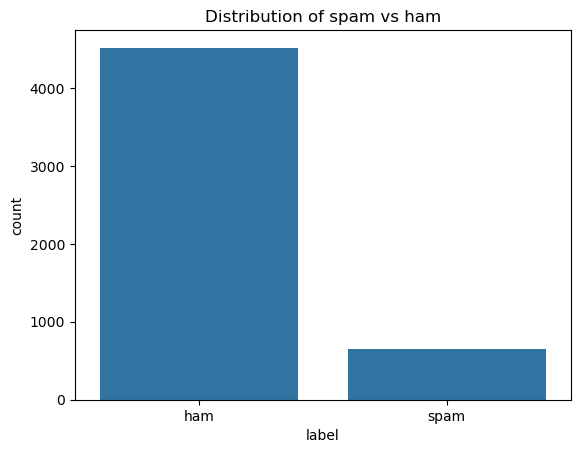

In [10]:
#Visualization: Distribution of spam vs ham
sns.countplot(x="label",data=cleaned_df)
plt.title("Distribution of spam vs ham")
plt.show()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_26964\2993188081.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df["message_length"]=cleaned_df["message"].apply(len)


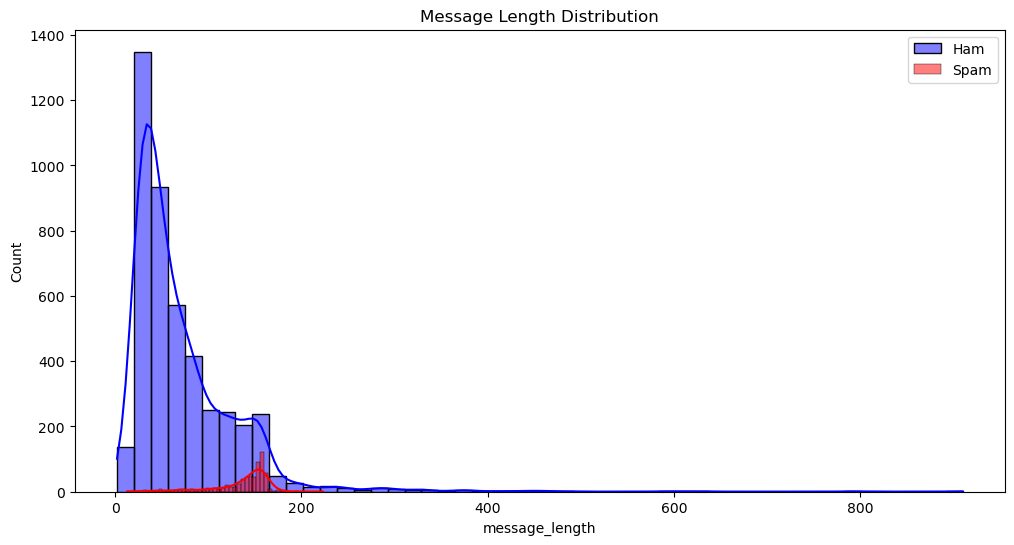

In [11]:
#Visualize the message length 
cleaned_df["message_length"]=cleaned_df["message"].apply(len)
plt.figure(figsize=(12,6))
sns.histplot(cleaned_df[cleaned_df["label"]=="ham"]["message_length"],label="Ham",color="blue",bins=50,kde=True)
sns.histplot(cleaned_df[cleaned_df["label"]=="spam"]["message_length"],label="Spam",color="red",bins=50,kde=True)
plt.title("Message Length Distribution")
plt.legend()
plt.show()

In [12]:
#Visualization: Word Clouds for spam and ham messages
spam_words="".join(cleaned_df[cleaned_df["label"]=="spam"]["message"])
ham_words="".join(cleaned_df[cleaned_df["label"]=="ham"]["message"])

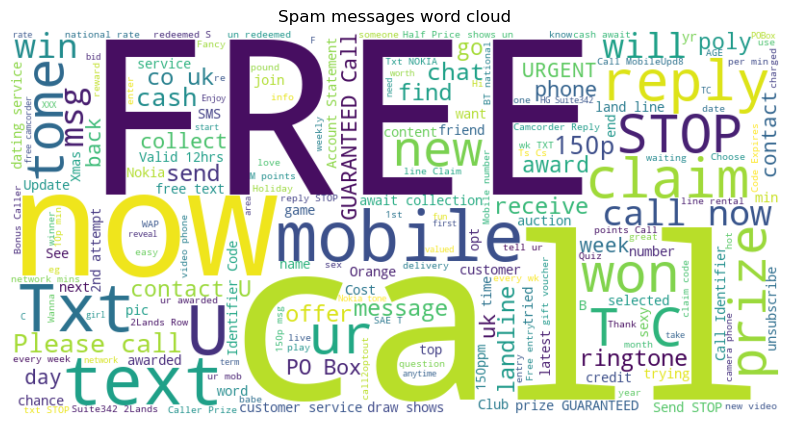

In [13]:
spam_wordcloud=WordCloud(width=800,height=400,background_color="white").generate(spam_words)
plt.figure(figsize=(10,5))
plt.imshow(spam_wordcloud,interpolation="bilinear")
plt.title("Spam messages word cloud")
plt.axis("off")
plt.show()

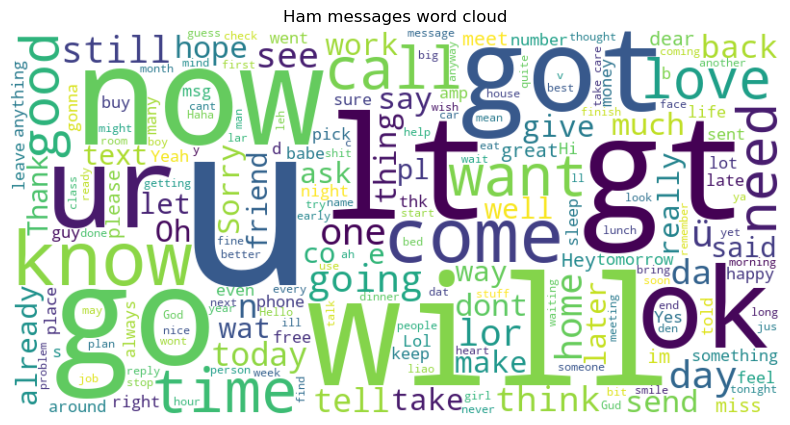

In [14]:
ham_wordcloud=WordCloud(width=800,height=400,background_color="white").generate(ham_words)
plt.figure(figsize=(10,5))
plt.imshow(ham_wordcloud,interpolation="bilinear")
plt.title("Ham messages word cloud")
plt.axis("off")
plt.show()

In [15]:
#EDA: Tokenization and common words analysis 
cleaned_df["tokens"]=cleaned_df["message"].apply(word_tokenize)
spam_tokens=[token for sublist in cleaned_df[cleaned_df["label"]=="spam"]["tokens"] for token in sublist]
ham_tokens=[token for sublist in cleaned_df[cleaned_df["label"]=="ham"]["tokens"] for token in sublist]

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_26964\1050802673.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df["tokens"]=cleaned_df["message"].apply(word_tokenize)


In [16]:
spam_common_words=Counter(spam_tokens).most_common(29)
ham_common_words=Counter(ham_tokens).most_common(29)

In [17]:
spam_common_df=pd.DataFrame(spam_common_words,columns=["words","count"])
ham_common_df=pd.DataFrame(ham_common_words,columns=["words","count"])

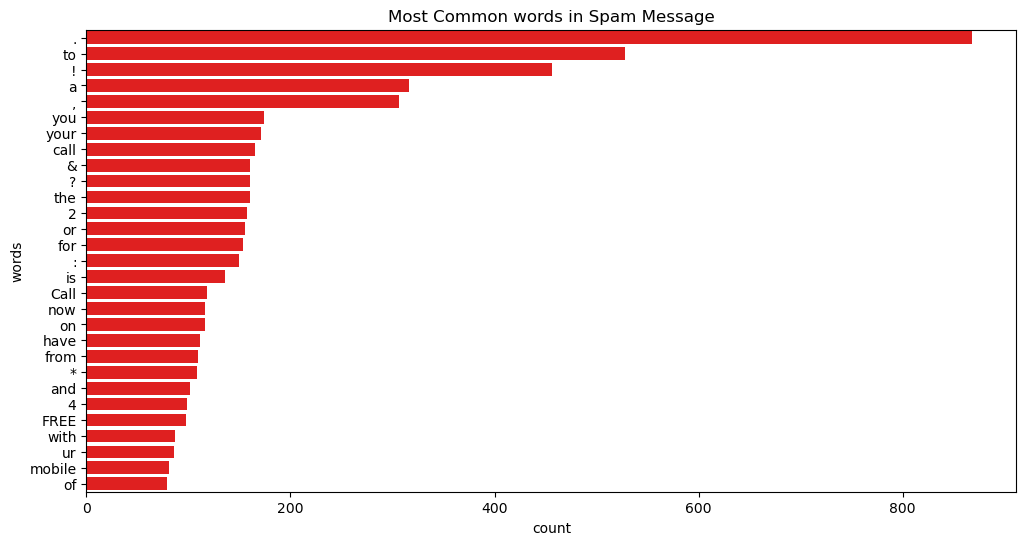

In [18]:
plt.figure(figsize=(12,6))
sns.barplot(x="count",y="words",data=spam_common_df,color="red")
plt.title("Most Common words in Spam Message")
plt.show()

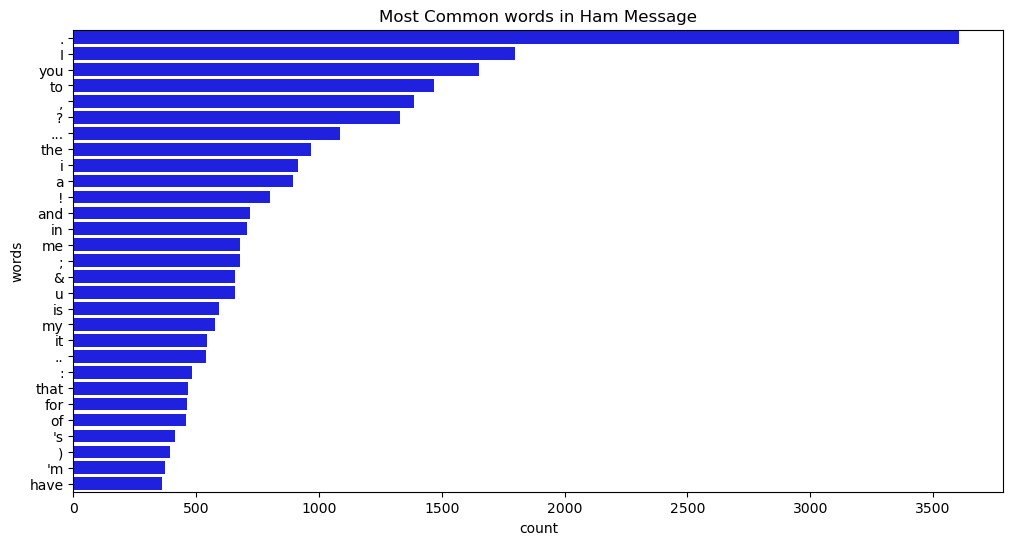

In [19]:
plt.figure(figsize=(12,6))
sns.barplot(x="count",y="words",data=ham_common_df,color="blue")
plt.title("Most Common words in Ham Message")
plt.show()

In [20]:
#Data Cleaning 
def clean_text(text):
    text=text.lower()
    text=re.sub(r"[^a-z\s]","",text)
    text="".join(text.split())
    return text

cleaned_df["message"]=cleaned_df["message"].apply(clean_text)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_26964\722641238.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df["message"]=cleaned_df["message"].apply(clean_text)


In [21]:
#Data Preprocessing
X=cleaned_df["message"]
y=cleaned_df["label"]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [22]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((4135,), (1034,), (4135,), (1034,))

In [23]:
#Feature Engineering: Convert text data to TF-IDF features
vectorizer=TfidfVectorizer()
X_train_tfidf=vectorizer.fit_transform(X_train)
X_test_tfidf=vectorizer.transform(X_test)

In [24]:
#Model selection and training
#Multinominal Naive Bayes
nb_model=MultinomialNB()
nb_model.fit(X_train_tfidf,y_train)

MultinomialNB()

In [25]:
#Linear SVC
svc_model=LinearSVC(dual=False)
svc_model.fit(X_train_tfidf,y_train)

LinearSVC(dual=False)

In [26]:
#Random Forest Classifier
rf_model=RandomForestClassifier()
rf_model.fit(X_train_tfidf,y_train)

RandomForestClassifier()

In [27]:
#Model Evaluation
nb_predictions=nb_model.predict(X_test_tfidf)
svc_predictions=svc_model.predict(X_test_tfidf)
rf_predictions=rf_model.predict(X_test_tfidf)

#Accuracy Computation
nb_accuracy=accuracy_score(y_test,nb_predictions)
svc_accuracy=accuracy_score(y_test,svc_predictions)
rf_accuracy=accuracy_score(y_test,rf_predictions)

#Print the accuracy
print(f"Multinomial Naive Bayes Accuracy: {nb_accuracy*100:.2f}%")
print(f"Linear SVC Accuracy: {svc_accuracy*100:.2f}%")
print(f"Random Forest Accuracy: {rf_accuracy*100:.2f}%")

Multinomial Naive Bayes Accuracy: 86.85%
Linear SVC Accuracy: 88.78%
Random Forest Accuracy: 88.78%
